# Connecting to a Local MySQL Database

In [ ]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import credentials
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

Need to create empty `__init__.py` file in order to import `.py` files (`credentials.py`) within a Jupyter notebook. Any changes to this `.py` file will only be reflected on Kernel restart.

In [ ]:
TABLENAME = 'trump'
TRACK_WORD = 'trump'

In [ ]:
def load_data_from_sql(tablename, minute_offset=None):
    try:
        connection = mysql.connector.connect(host=credentials.HOST,
                                             database=credentials.DATABASE,
                                             user=credentials.USER,
                                             password=credentials.PASSWORD)
        if (connection.is_connected()):
            db_info = connection.get_server_info()
            print("Connect to MySQL Server version ", db_info)
            cursor = connection.cursor()
            cursor.execute("select database();")
            record = cursor.fetchone()
            print("Connected to database: ", record)

            if minute_offset:
                time_now = datetime.datetime.utcnow()
                time_delta = datetime.timedelta(hours=round(minute_offset / 60), minutes=round(minute_offset % 60))
                time_start = time_now - time_delta
                sql = "SELECT * FROM {} WHERE created_at >= '{}'".format(tablename, time_start)
            else:
                sql = "SELECT * FROM {}".format(tablename)

            # Read into df
            df = pd.read_sql(sql, con=connection)
            
            # Additional columns -- should this be > or < 0 rather than a cast?
            # df["polarity_flag"] = df["polarity"].astype(int)
            # df["subjectivity_flag"] = df["subjectivity"].astype(int)
            
            df["polarity_flag"] = ((df["polarity"] > 0) * 1) + ((df["polarity"] < 0) * -1)
            df["subjectivity_flag"] = ((df["subjectivity"] > 0) * 1) + ((df["subjectivity"] < 0) * -1)    
            
    except Error as e:
        print("Error connecting:", e)
    finally:
        if (connection.is_connected()):
            cursor.close()
            connection.close()
            print("Connection closed")
    
    return df

In [ ]:
df = load_data_from_sql(TABLENAME)

Connect to MySQL Server version  8.0.19
Connected to database:  ('dev',)
Connection closed


In [ ]:
df.shape

(399, 17)

In [ ]:
df.head()

,id_str,created_at,text,polarity,subjectivity,user_created_at,user_id_str,user_screen_name,user_location,user_description,user_followers_count,longitude,latitude,retweet_count,favorite_count,polarity_flag,subjectivity_flag
0,1246533260005515269,2020-04-04 20:21:03,"The bullshit is so deep, they don't make boots...",0.0533,0.4800,2015-12-09 05:25:31,4423287267,karenfadus1,"Fort Wayne, IN","Jill of all trades , recluse",663,None,None,0,0,1,1
1,1246533259691003904,2020-04-04 20:21:03,Oh hey remember when Donny deutsch said on mor...,0.1375,0.4750,2010-09-20 02:57:30,192770486,DonnaMgraduates,"New Hampshire, USA.","The More You Learn, The More You Bern...Medica...",3033,None,None,0,0,1,1
2,1246533260445794304,2020-04-04 20:21:03,@rsa671 @gourav179768 @realDonaldTrump @Bankof...,-0.0389,0.6167,2017-08-18 21:29:10,898658052227735553,DavePerrino,"California, USA",None,1479,None,None,0,0,-1,1
3,1246533260513095681,2020-04-04 20:21:03,"About 45 minutes later than anticipated, Presi...",-0.2500,0.5000,2012-03-12 00:01:52,521795009,MikenzieFrost,"Lansing, MI",Sinclair Broadcast Group Michigan Political Re...,2593,None,None,0,0,-1,1
4,1246533262111117313,2020-04-04 20:21:03,A @CBSNews Special Report is now live on @WKYT...,0.0950,0.4554,2013-05-22 01:11:00,1447670179,GarrettWKYT,"Lexington, Ky.",@WKYT Anchor/Reporter. @universityofky alum. B...,3144,None,None,0,0,1,1


In [ ]:
df.dtypes

id_str                          object
created_at              datetime64[ns]
text                            object
polarity                       float64
subjectivity                   float64
user_created_at                 object
user_id_str                     object
user_screen_name                object
user_location                   object
user_description                object
user_followers_count             int64
longitude                       object
latitude                        object
retweet_count                    int64
favorite_count                   int64
polarity_flag                    int32
subjectivity_flag                int32
dtype: object

In [ ]:
# Clean and transform data to enable time series
result = df.groupby(                                        
      [pd.Grouper(key='created_at', freq='2s'), 'polarity_flag']
    ).count().unstack(fill_value=0).stack().reset_index()

result = result.rename(columns=                             
    { "id_str": "Num of '{}' mentions".format(TRACK_WORD),  
      "created_at":"Time in UTC" })

In [ ]:
time_series = result["Time in UTC"][result['polarity_flag']==0].reset_index(drop=True)

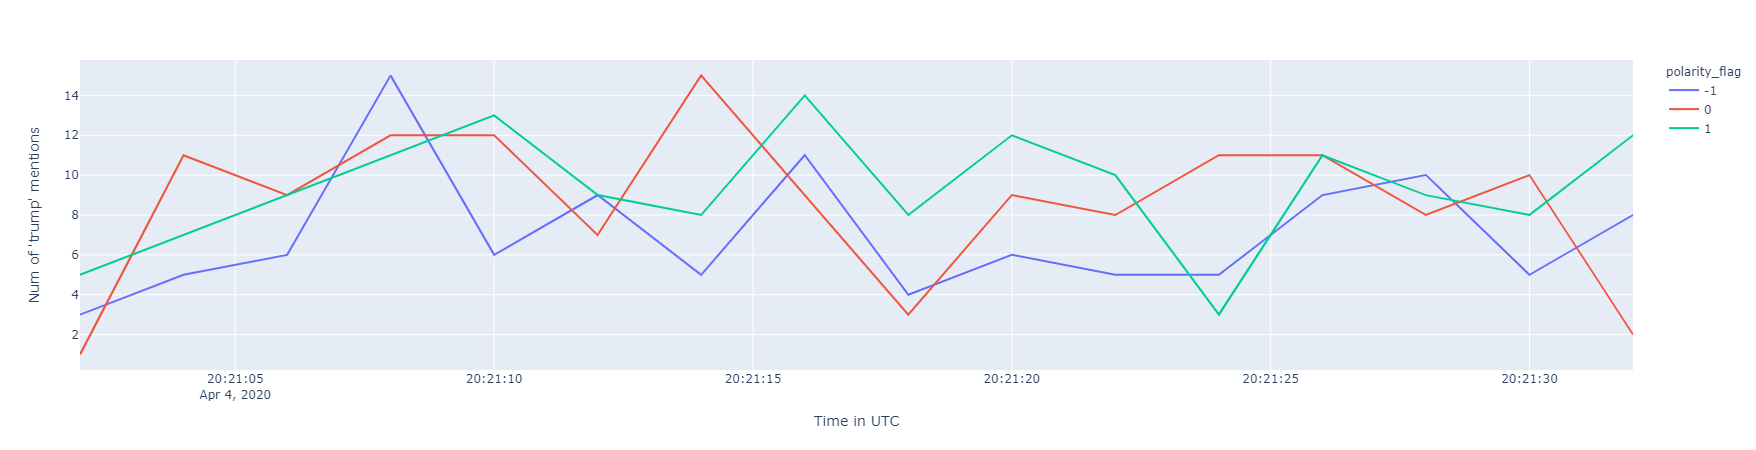

In [ ]:
fig = px.line(result, x='Time in UTC',                      
    y="Num of '{}' mentions".format(TRACK_WORD),            
    color='polarity_flag')
fig.show()

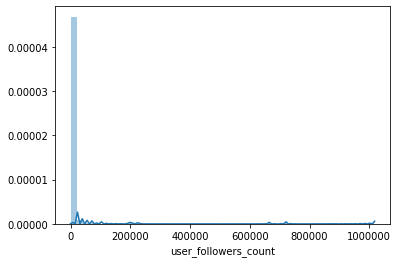

In [ ]:
sns.distplot(df["user_followers_count"])
plt.show()

In [ ]:
df[["user_screen_name", "user_followers_count"]].sort_values(by="user_followers_count", ascending=False)

,user_screen_name,user_followers_count
266,QuickTake,1017077
268,ddale8,721666
249,chuckwoolery,663182
385,Politics_PR,226645
341,thebradfordfile,203884
...,...,...
394,dawn27331807,0
326,IndianNewsBuzz,0
196,DavidOs50193386,0
198,Watson26440709,0


In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=[2, 1, 4, 3]))
# fig.add_trace(go.Bar(y=[1, 4, 3, 2]))
# fig.update_layout(title = 'Hello Figure')
# fig.show()